**Import** Libraries

In [1]:
from __future__ import unicode_literals, print_function, division
import numpy as np


**Objective : Design RNN for predicting sequence of characters from training data**

In [13]:
class DataReader:
  def __init__(self):
    self.data = "All the faith he had had had had no effect on the outcome of his life"
    chars = list(set(self.data))
    chars.append(" ")
    self.char_to_ix = {ch:i for (i,ch) in enumerate(chars)}
    self.ix_to_char = {i:ch for (i,ch) in enumerate(chars)}
    self.seq_length = len(self.data)
    self.vocab_size = len(chars)
    print(self.seq_length)

  def get_inputs_targets(self, data):
   inputs_str = data
   target_str = data[1:] 
   target_str = target_str + " "  
   inputs = [self.char_to_ix[ch] for ch in inputs_str] 
   targets = [self.char_to_ix[ch] for ch in target_str]
   return inputs, targets

datareader = DataReader()
datareader.get_inputs_targets(datareader.data)


69


([6,
  13,
  13,
  16,
  10,
  15,
  12,
  16,
  2,
  3,
  1,
  10,
  15,
  16,
  15,
  12,
  16,
  15,
  3,
  7,
  16,
  15,
  3,
  7,
  16,
  15,
  3,
  7,
  16,
  15,
  3,
  7,
  16,
  4,
  11,
  16,
  12,
  2,
  2,
  12,
  14,
  10,
  16,
  11,
  4,
  16,
  10,
  15,
  12,
  16,
  11,
  5,
  10,
  14,
  11,
  0,
  12,
  16,
  11,
  2,
  16,
  15,
  1,
  8,
  16,
  13,
  1,
  2,
  12],
 [13,
  13,
  16,
  10,
  15,
  12,
  16,
  2,
  3,
  1,
  10,
  15,
  16,
  15,
  12,
  16,
  15,
  3,
  7,
  16,
  15,
  3,
  7,
  16,
  15,
  3,
  7,
  16,
  15,
  3,
  7,
  16,
  4,
  11,
  16,
  12,
  2,
  2,
  12,
  14,
  10,
  16,
  11,
  4,
  16,
  10,
  15,
  12,
  16,
  11,
  5,
  10,
  14,
  11,
  0,
  12,
  16,
  11,
  2,
  16,
  15,
  1,
  8,
  16,
  13,
  1,
  2,
  12,
  16])

**RNN** **Architecture**
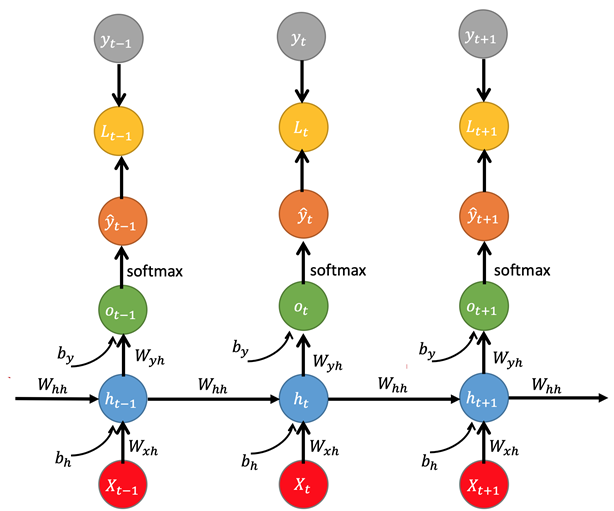

Softmax Modification to control overflow problems: 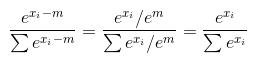

**RNN Forward Pass:**


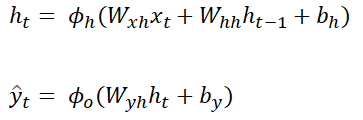

In [14]:

class RNN:
  def __init__(self, hidden_size, vocab_size,seq_length,learning_rate):
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.seq_length = seq_length
    self.learning_rate = learning_rate
    # Model_Parameters
    self.W_xh = np.random.uniform(-np.sqrt(1./vocab_size),np.sqrt(1./vocab_size), size=(hidden_size,vocab_size))
    self.W_hh = np.random.uniform(-np.sqrt(1./hidden_size),np.sqrt(1./hidden_size), size=(hidden_size,hidden_size))
    self.W_yh = np.random.uniform(-np.sqrt(1./hidden_size),np.sqrt(1./hidden_size), size=(vocab_size,hidden_size))
    
    #Added biases
    self.bh = np.zeros((hidden_size, 1)) # hidden bias
    self.by = np.zeros((vocab_size, 1)) # output bias
    
    # memory variables
    self.mW_xh = np.zeros_like(self.W_xh)
    self.mW_hh = np.zeros_like(self.W_hh)
    self.mW_yh = np.zeros_like(self.W_yh)
    self.mbh = np.zeros_like(self.bh)
    self.mby = np.zeros_like(self.by)
    

  
  def softmax(self, x):
    p = np.exp(x-np.max(x))
    return p / np.sum(p)


  def forward(self, inputs,hprev):
    xs, hs, os, ycap = {},{},{},{}
    hs[-1] = np.copy(hprev)
    for t in range(len(inputs)):
      xs[t] = np.zeros((self.vocab_size, 1))
      xs[t][inputs[t]] = 1 # one-hot encoding
      hs[t] = np.tanh(np.dot(self.W_hh,hs[t-1]) + np.dot(self.W_xh,xs[t]) + self.bh) 
      os[t] = np.dot(self.W_yh,hs[t]) + self.by
      ycap[t] = self.softmax(os[t])
      #print(xs[t].shape,hs[t].shape,os[t].shape,ycap[t].shape)
    return xs, hs, ycap

  def loss(self, ycap, targets):
    return sum(-np.log(ycap[t][targets[t]]) for t in range(self.seq_length))

  def backward(self, xs, hs, ycap,targets):
    dW_xh = np.zeros_like(self.W_xh)
    dW_hh = np.zeros_like(self.W_hh)
    dW_yh = np.zeros_like(self.W_yh)
    dhnext = np.zeros_like(hs[0])
    
    #Gradient for biases
    dL_dbh = np.zeros_like(self.bh)
    dL_dby = np.zeros_like(self.by)
    
    for t in reversed(range(self.seq_length)):
        
      #Compute yhat - y.
      d_yy_cap = np.copy(ycap[t])
      d_yy_cap[targets[t]]-= 1
      
      # Add this line to calculate gradient with repect to dby.
      dL_dby+= d_yy_cap
      
      dW_yh += np.dot(d_yy_cap,hs[t].T)
      
      # Compute W^Tyh(y-ycap)
      dL_dh = np.dot(self.W_yh.T,d_yy_cap) + dhnext
      # Diffrentiaion of tanh(x) is (1-tanh^2(x))
      dL_dh_dtanh = (1 -hs[t]*hs[t])*dL_dh
      
      #dL_dbh is W^Tyh(y-ycap) * derivation of tanh(hs) so add below line to compute dL_dbh.
      dL_dbh+= dL_dh_dtanh
    
    
      dW_hh+= np.dot(dL_dh_dtanh, hs[t-1].T)
      dW_xh+= np.dot(dL_dh_dtanh, xs[t].T)

      dhnext = np.dot(self.W_hh.T,dL_dh_dtanh)

    return dW_xh, dW_hh, dW_yh, dL_dby, dL_dbh
  
    
  #Various gradient optimization methods i had used.
  def SGD(self, dW_xh, dW_hh, dW_yh, dL_dby, dL_dbh):
    for param, dparam in zip([self.W_xh, self.W_hh, self.W_yh, self.by, self.bh],[dW_xh, dW_hh, dW_yh, dL_dby, dL_dbh]):
      param+= -self.learning_rate*dparam
  
  def adaGrade(self, dW_xh, dW_hh, dW_yh,dL_dby, dL_dbh):
    for param, dparam,mem in zip([self.W_xh, self.W_hh, self.W_yh,self.by,self.bh],
                                 [dW_xh, dW_hh, dW_yh,dL_dby, dL_dbh],
                                 [self.mW_xh, self.mW_hh, self.mW_yh,self.mby, self.mbh]):
      mem += dparam * dparam
      param += -self.learning_rate * dparam / np.sqrt(mem + 1e-3) #Small offset to avoid divison by zero
  
  def RMSprop(self, dW_xh, dW_hh, dW_yh,dL_dby, dL_dbh):
    for param, dparam,mem in zip([self.W_xh, self.W_hh, self.W_yh,self.by,self.bh],
                                 [dW_xh, dW_hh, dW_yh,dL_dby, dL_dbh],
                                 [self.mW_xh, self.mW_hh, self.mW_yh,self.mby, self.mbh]):
      mem = 0.9*mem + (1-0.9)*(dparam * dparam)
      param += -self.learning_rate * dparam / np.sqrt(mem + 1e-3) #Small offset to avoid divison by zer

        
  def update_model(self, dW_xh, dW_hh, dW_yh, dL_dby, dL_dbh):
    #self.RMSprop(dW_xh, dW_hh, dW_yh, dL_dby, dL_dbh)
    self.SGD(dW_xh, dW_hh, dW_yh, dL_dby, dL_dbh)
    #self.adaGrade(dW_xh, dW_hh, dW_yh, dL_dby, dL_dbh)
    
    
    
    
  def predict(self, data_reader, start_char, predict_len):
    x = np.zeros((self.vocab_size,1))
    ix = datareader.char_to_ix[start_char]
    x[ix] = 1
    indexes=[ix]
    hs = np.zeros((self.hidden_size, 1))
    for t in range(predict_len):
      hs = np.tanh(np.dot(self.W_hh,hs) + np.dot(self.W_xh,x) + self.bh)
      os = np.dot(self.W_yh,hs) + self.by
      ycap = self.softmax(os)
      ix = np.random.choice(range(self.vocab_size), p = ycap.ravel()) 
      x = np.zeros((self.vocab_size, 1))
      x[ix]= 1
      indexes.append(ix)
    
    txt = ''.join(data_reader.ix_to_char[i] for i in indexes)
    return txt

  



datareader = DataReader()
inputs, targets = datareader.get_inputs_targets(datareader.data)
hidden_size = 30
rnn = RNN(hidden_size,datareader.vocab_size,len(inputs), 1e-03)
loss = 100
iter = 0
while(iter < 10000):
  hprev= np.zeros((hidden_size, 1))
  xs, hs , ycap = rnn.forward(inputs,hprev)
  loss = rnn.loss(ycap, targets) 
  dW_xh, dW_hh, dW_yh, dL_dby, dL_dbh =  rnn.backward(xs, hs , ycap,targets)
  rnn.update_model(dW_xh, dW_hh, dW_yh, dL_dby, dL_dbh)
  if not iter%1000:
    print("iter num", iter, loss)
    out = rnn.predict(datareader,'A', rnn.seq_length)
    print(out)
  iter+=1

  




      











69
iter num 0 [194.5387091]
Ahtcl n Annc ufffme aietslfcmetlashisdetiaet nsnioilsll fhlouihaeco ot
iter num 1000 [6.50311735]
All the faith he had had had had no fffect oc the las lith  li the oif
iter num 2000 [1.64148478]
All the faith he had had had had no effect on the outcome of his life 
iter num 3000 [0.883951]
All the faith he had had had had no effect on the outcome of his life 
iter num 4000 [0.59366618]
Ahl the fuith ha thfe no hadthomenoue mo thfe  o e fe ti hadeef hle ha
iter num 5000 [0.44250688]
All the faitl he had had had had no effect on the outcome of his life 
iter num 6000 [0.3506952]
All the faith he had had had had no effect on the outcome of his life 
iter num 7000 [0.2893667]
All the faith he had had had had no effect on the outcome of his life 
iter num 8000 [0.24566855]
All the faith he had had had had no effect on the outcome of his life 
iter num 9000 [0.21304213]
All the faith he had had had had no effectcont he oad hf efe oo th e f


**Gradient Backpropgation via Recursion:**

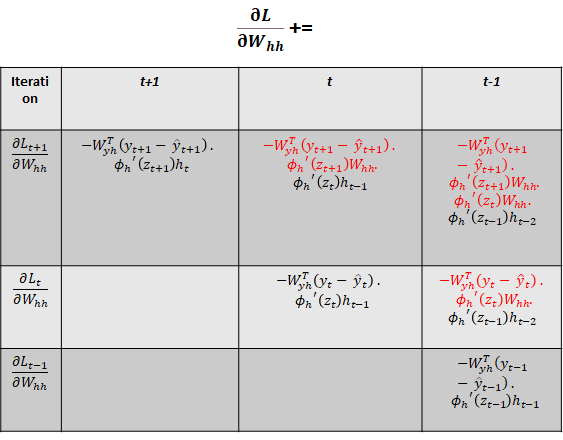

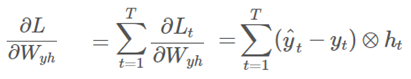

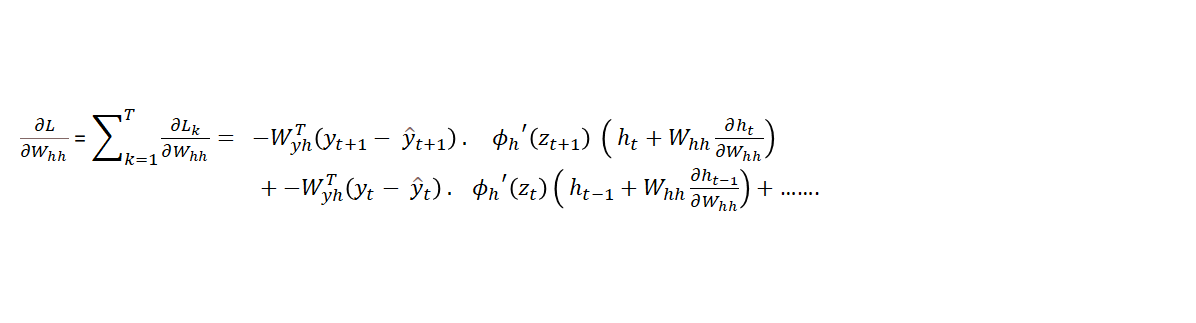